## To run this notebook you have to download 

1. the folder **'Bit_Bot'** which contains the model,  from the link : https://drive.google.com/drive/folders/1OmgxNwnpPvdYUxYb_yplrlv1mjhfkQWi?usp=sharing and store it under the directory ./DS1200007_1200004_1200012/best_model/  .

2. the file **tensor_dataset.zip** : 
https://drive.google.com/file/d/1s2lu2OLRx3OuS1x14vE6_KjDYiMUKZ9S/view?usp=sharing,    under the directory ./DS1200007_1200004_1200012/Dataset/

# BiT Model of the Bot


*   Load Model
*   Inference on Test data
*   Set optimal thresholds per class
*   Quantitative analysis
*   Qualitative analysis




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import time
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import numpy
import keras
import os
import pathlib
import seaborn as sns
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix
import collections

# Set your own directory

In [ ]:
src_dir = '/content/drive/MyDrive'

In [ ]:
!unzip "$src_dir/DS1200007_1200004_1200012/Dataset/tensor_dataset.zip"

Archive:  /content/drive/MyDrive/captcha_share/Dataset/tensor_dataset.zip
   creating: tensor_dataset/3544483170186818736/
   creating: tensor_dataset/3544483170186818736/00000000.shard/
  inflating: tensor_dataset/3544483170186818736/00000000.shard/00000000.snapshot  
 extracting: tensor_dataset/snapshot.metadata  


In [ ]:
my_classes=['Bicycle','Bridge','Bus','Car', 'Chimney', 'Crosswalk','Hydrant','Motorcycle',  'Palm', 'Traffic Light','Boat']
NUM_CLASSES = len(my_classes)


In [ ]:
directory="./tensor_dataset"  
new_dataset = tf.data.experimental.load(directory,{'image': tf.TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None),
 'label': tf.TensorSpec(shape=(11,), dtype=tf.float32, name=None)}) 


## Split dataset 70% / 20% / 10%

In [ ]:
test_ratio = 0.90   
train_ratio = 0.70

ds_size= new_dataset.cardinality().numpy()
ds_train2=new_dataset.take(ds_size*test_ratio)
ds_test=new_dataset.skip(ds_size*test_ratio)
ds_train = ds_train2.take(ds_size*train_ratio)
ds_val = ds_train2.skip(ds_size*train_ratio)

ds_test_images = np.array([f['image'] for f in ds_test])


# Show samples of dataset

36 Samples from the dataset


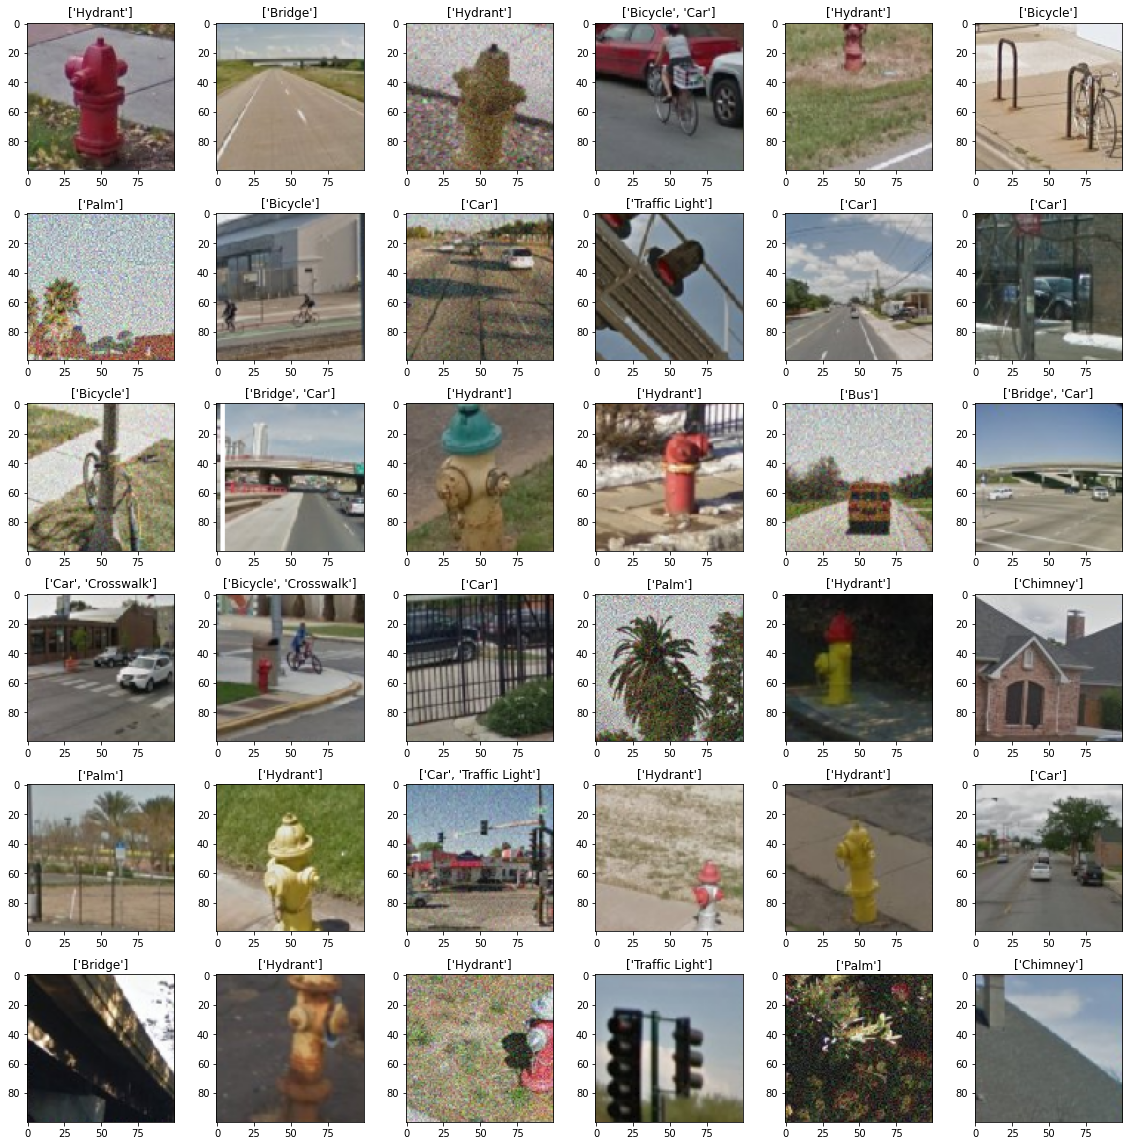

In [ ]:
def show_samples(dataset):
    fig=plt.figure(figsize=(16,16))
    columns = 6
    rows = 6
    print(columns*rows,"Samples from the dataset")
    i=1
    for f in dataset.take(columns*rows): 
        fig.add_subplot(rows, columns, i)
        fig.tight_layout(pad=1.0)
        plt.imshow(f['image'])
        plt.title(str([my_classes[x[0]] for x in np.argwhere(f['label']==1)]))        
        i=i+1
    plt.show()
    
show_samples(new_dataset)

# Summary dataset

In [ ]:
def summary_dataset(dataset):
    isolLabel=dict(zip(my_classes, [0 for i in range(len(my_classes))]))
    dict3=dict(zip(my_classes, [[0]*4 for i in range(len(my_classes))]))
    pairLabel={} 
    numofLabel={}

    for f in dataset:
        cl_list=[my_classes[x[0]] for x in np.argwhere(f['label']==1)]
        cl_list_len=len(cl_list)  

        for l in cl_list:
            isolLabel[l]+=1
            dict3[l][cl_list_len-1]+=1

        cl_list.sort()
        str_cl_list='-'.join(cl_list)
        try:
            pairLabel[str_cl_list]+=1
        except KeyError:
            #print ("New Entry")
            pairLabel[str_cl_list]= 1

        
        try:
            numofLabel[str(cl_list_len)+'-label']+=1
        except KeyError:
            #print ("New Entry")
            numofLabel[str(cl_list_len)+'-label']= 1
            
    return numofLabel,isolLabel,pairLabel,dict3

summary_dataset=summary_dataset(new_dataset)

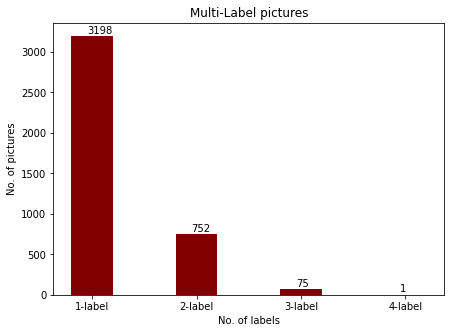

In [ ]:
###### numOfLabel  ####
def graph_numOfLabel(numofLabel):
  numOfLabels = list(numofLabel.keys())
  num_img = list(numofLabel.values())
    
  fig = plt.figure(figsize = (7, 5))
  
  # creating the bar plot
  plt.bar(numOfLabels, num_img, color ='maroon',
          width = 0.4)
  for i in range(len(numOfLabels)):
      plt.text(i-0.05, num_img[i]+30,num_img[i])
      
  plt.xlabel("No. of labels")    
  plt.ylabel("No. of pictures")
  plt.title("Multi-Label pictures")
  plt.show()
  
graph_numOfLabel(summary_dataset[0])

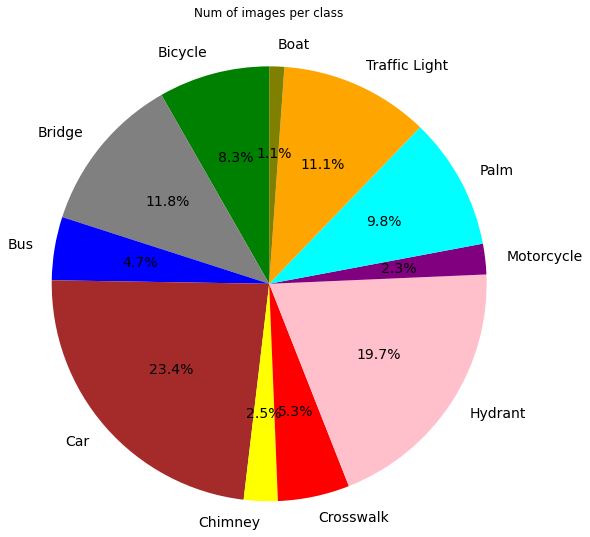

In [ ]:
def grapg_isolLabel(isolLabel):  
  label_class = list(isolLabel.keys())
  num_img = list(isolLabel.values())
  colors=['green','gray','blue','brown','yellow','red','pink','purple','cyan','orange','olive',]
  patches, texts, autotexts=plt.pie(num_img, labels=label_class, autopct='%1.1f%%',radius=2.5, textprops={'fontsize': 14}, colors=colors,
          startangle=90) 
  plt.title("Num of images per class",y=1.7)
  plt.show()
  
grapg_isolLabel(summary_dataset[1])

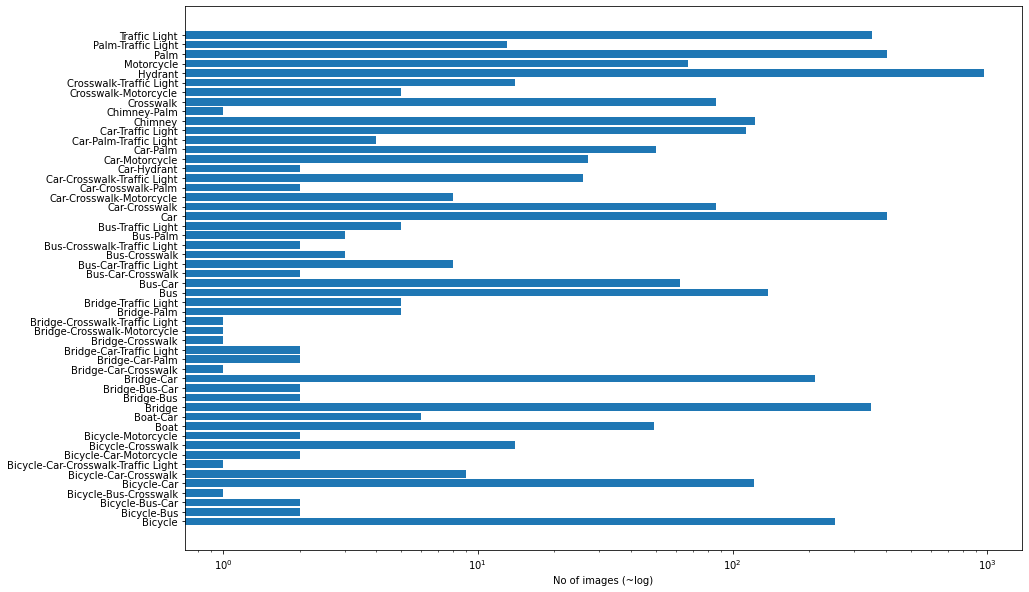

In [ ]:
def graph_pairLabel(pairLabel):
  ord_pairLabel=collections.OrderedDict(sorted(pairLabel.items()))
  pair_label_class = list(ord_pairLabel.keys())
  num_img = list(ord_pairLabel.values())
  fig = plt.figure(figsize = (15, 10))

  plt.xscale('log')
  plt.barh(pair_label_class,num_img)
  plt.xlabel('No of images (~log)')
  plt.show()
  
graph_pairLabel(summary_dataset[2])

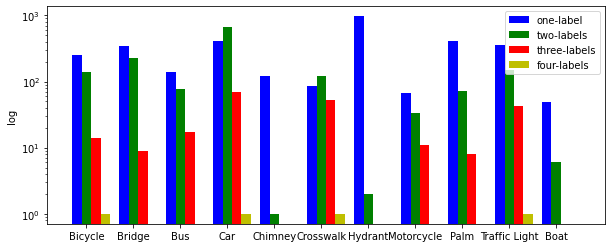

In [ ]:
def graph_classMultiLabel(dict3):
  x = np.arange(len(my_classes))  # the label locations
  legend=['one-label','two-labels','three-labels','four-labels']
  y=[dict3[i][0] for i in my_classes ]
  z=[dict3[i][1] for i in my_classes ]
  k=[dict3[i][2] for i in my_classes ]
  l=[dict3[i][3] for i in my_classes ]

  plt.figure(figsize = (10, 4))
  ax = plt.subplot(111)
  b1 = ax.bar(x -0.2, y, width=0.2, color='b', align='center')
  b2 = ax.bar(x, z, width=0.2, color='g', align='center')
  b3 = ax.bar(x + 0.2 , k, width=0.2, color='r', align='center')
  b4 = ax.bar(x + 0.4 , l, width=0.2, color='y', align='center')

  ax.set_xticks(x)
  ax.set_xticklabels(my_classes)
  ax.legend((b1,b2,b3,b4),legend)
  plt.yscale('log')
  plt.ylabel('log')
  plt.show()

graph_classMultiLabel(summary_dataset[3])

# Load Model

In [ ]:
Bit = keras.models.load_model(os.path.join(src_dir,"DS1200007_1200004_1200012/best_model/Bit_Bot"))


## Test and validation pipelines

In [ ]:
BATCH_SIZE = 32
RESIZE_TO = 300     #resize test images for inferenece 

SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

AUTOTUNE = tf.data.experimental.AUTOTUNE

def cast_to_tuple(features):
  return (features['image'], features['label'])

def preprocess_test(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  return features

pipeline_val = (ds_val        
        .map(preprocess_test, num_parallel_calls=1)        
        .map(cast_to_tuple)  # for keras model.fit
        .batch(BATCH_SIZE)
        .prefetch(2))

pipeline_test = (ds_test      
        .map(preprocess_test, num_parallel_calls=1)        
        .map(cast_to_tuple)  # for keras model.fit
        .batch(BATCH_SIZE)
        .prefetch(2))


 ## Compile the model to evaluate in test set

In [ ]:
# Define optimiser and loss

lr = 0.003# * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)


loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Bit.compile(optimizer=optimizer,
              loss=loss_fn,
              #metrics=["categorical_accuracy"]
              metrics=[tf.keras.metrics.BinaryAccuracy()]              )

Bit.evaluate(pipeline_val)

26/26 [==============================] - 94s 3s/step - loss: 0.0583 - binary_accuracy: 0.9771


[0.05830210819840431, 0.9770752191543579]

# Inference

In [ ]:
def preprocess_image_inference(image):
  image = np.array(image)
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  img_reshaped=tf.image.resize(img_reshaped, [RESIZE_TO, RESIZE_TO])
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image


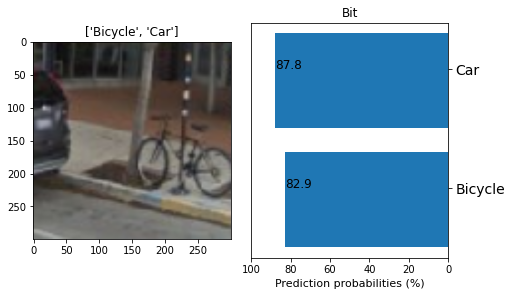

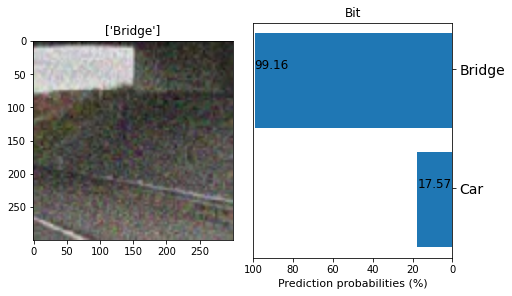

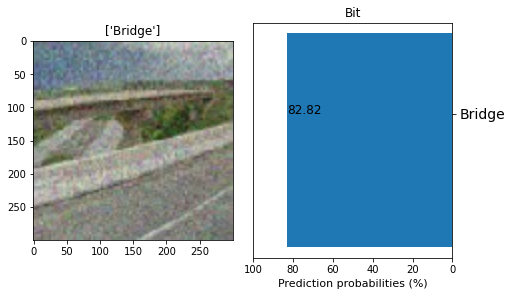

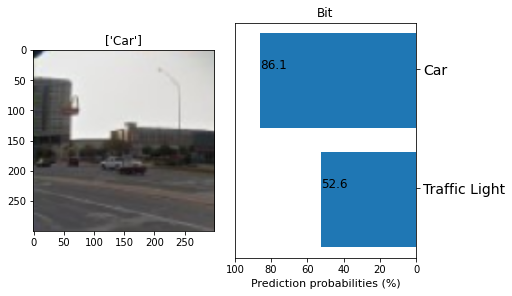

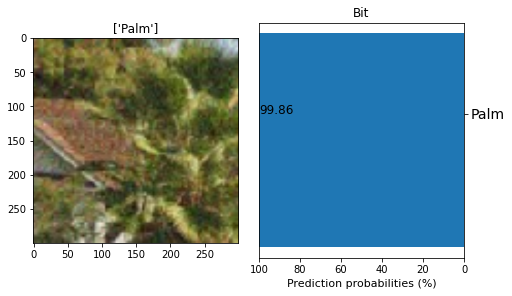

In [ ]:
MIN_SCORE = 15    ###### user defined threshold  ####

for f in ds_test.take(5):  ##### get predictions for the first 5 images from ds_test
    image=preprocess_image_inference(f['image'])  
    fig, axes = plt.subplots(1,2 , figsize=(7, 4), squeeze=False ,constrained_layout = True)

    ax1 = axes[0,0]
    ax1.imshow(image[0])
    ax1.set_title([my_classes[x[0]] for x in np.argwhere(f['label'].numpy()==1)])
    logits=Bit(image)

    if len(logits.shape) > 1:
      logits = tf.reshape(logits, [-1])
    ax2 = axes[0,1]
    logits_max = np.max(logits)
    classes = []
    scores = []
    for index, j in enumerate(np.argsort(logits)[::-1]):
      score = 1.0/(1.0 + np.exp(-logits[j]))*100
      if score < MIN_SCORE: break      
      classes.append(my_classes[j])     
      scores.append(score)
    ax2.barh(np.arange(len(scores)) + 0.1, scores)
    for i in range(len(scores)):
        ax2.text(scores[i],i,np.round(scores[i],2),fontsize=12)
    ax2.set_title('Bit')
    ax2.set_xlim(0, 100)
    ax2.set_yticks(np.arange(len(scores)))
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticklabels(classes , rotation=0, fontsize=14)
    ax2.invert_xaxis()
    ax2.invert_yaxis()
    ax2.set_xlabel('Prediction probabilities (%)', fontsize=11)
    plt.show()  

# Functions : Prediction & True Labels -Metrics - Confusion Matrix

In [ ]:
## Calculate metrics PR RC F1 ## 

def metrics_PR_RC(conf_matrix):
  metrics_per_class = []
  for matrix in conf_matrix:
    pr = round(matrix[1,1]/( matrix[1,1]+ matrix[0,1]),4)
    rc = round(matrix[1,1]/( matrix[1,1]+ matrix[1,0]),4)
    f1=round(2*(pr*rc)/(pr+rc),4)
    metrics_per_class.append((pr,rc,f1))
  df_metrics = pd.DataFrame.from_records(metrics_per_class,index=my_classes, columns =['Precision','Recall','F1-score'])
  df_mean = pd.DataFrame({'Precision':df_metrics['Precision'].mean(), 'Recall':df_metrics['Recall'].mean(),'F1-score': df_metrics['F1-score'].mean()},index=['Mean_value',])
  df_metrics = df_metrics.append(df_mean)
  return df_metrics

In [ ]:
### Optimal value of threshold for each class  ####

def thres_class(saved_model, ds=ds_val, pipeline = pipeline_val) :
  pred_logits = saved_model.predict(pipeline)
  min_th = [k for k in  np.arange(10,65,2)]  #   min_k = [k for k in  np.arange(10,45,0.5)] - > more accurate
  df_F1 = pd.DataFrame()
  true_labels = np.array([f['label'] for f in ds]).astype(int)
  ds_test_images = np.array([f['image'] for f in ds])
  score_pred = 1.0/(1.0 + np.exp(-pred_logits))*100
  for MIN_SCORE in min_th :
    pred_labels = np.where(score_pred>MIN_SCORE,1,0)
    conf_matrix= multilabel_confusion_matrix(true_labels,pred_labels)
    temp = metrics_PR_RC(conf_matrix)['F1-score']
    temp = temp.rename(MIN_SCORE) 
    df_F1 =  pd.concat([df_F1, temp], axis=1)
  thres_per_class = df_F1.idxmax(axis=1).values
  #print (df_F1)
  return thres_per_class , df_F1 

In [ ]:
def disp_heatmap_per_class(conf_matrix):
  fig,axes = plt.subplots(3 ,4 , figsize=(20, 15), squeeze=False ,constrained_layout = True)
  for ind, c in enumerate (conf_matrix):
    group_counts = ["{0:0.0f}".format(value) for value in
                    c.flatten()]
    labels = np.asarray(group_counts).reshape(2,2)  
    #ax = axes[ind]
    ax=sns.heatmap(c, annot=labels ,fmt='',ax=axes[ind//4,ind%4], cmap='Blues')
    ax.set_title(my_classes[ind]+'\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    #  Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
  fig.delaxes(axes[2,3])
  plt.show()


In [ ]:
### compute prediction and true label for each image ###

def compute_tr_pr_labels (thres):  
  true_labels = np.array([f['label'] for f in ds_test]).astype(int)
  pred_labels = []

  for score in score_pred:
    pred_label = []  
    for ind,sc in enumerate(score):  
      if sc> thres[ind]:
        pred_label.append(1)
      else:
        pred_label.append(0)
    pred_labels.append(pred_label)
  pred_labels = np.array(pred_labels)
  return true_labels, pred_labels


# Call the above functions

In [ ]:
thres_per_class, df_F1 =  thres_class(Bit) 

## optimal for Bit ##
#thres_per = [26. , 23. , 24.5, 43.5, 33.5, 18. , 11. , 41. , 37. , 36. , 18. , 33.5]  #Bit

#thres_per_class = [50 for x in range (NUM_CLASSES)]
pred_logits = Bit.predict(pipeline_test)
score_pred = 1.0/(1.0 + np.exp(-pred_logits))*100
tr_pr_labels = compute_tr_pr_labels(thres_per_class)
conf_matrix= multilabel_confusion_matrix(*tr_pr_labels)
metrics = metrics_PR_RC (conf_matrix)

In [ ]:
pd.DataFrame(thres_per_class[:-1],my_classes).T  # optimal thresholds

,Bicycle,Bridge,Bus,Car,Chimney,Crosswalk,Hydrant,Motorcycle,Palm,Traffic Light,Boat
0,26,24,22,44,34,18,12,42,38,36,18


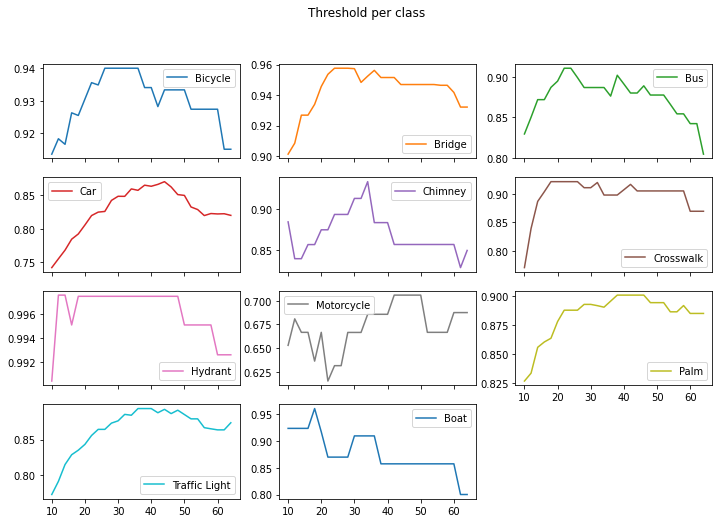

In [ ]:
df_F1.iloc[:-1,:].T.plot(subplots=True,figsize=(12,8),layout=(4,3),title='Threshold per class');
#plt.show()

# Display heatmap per class 



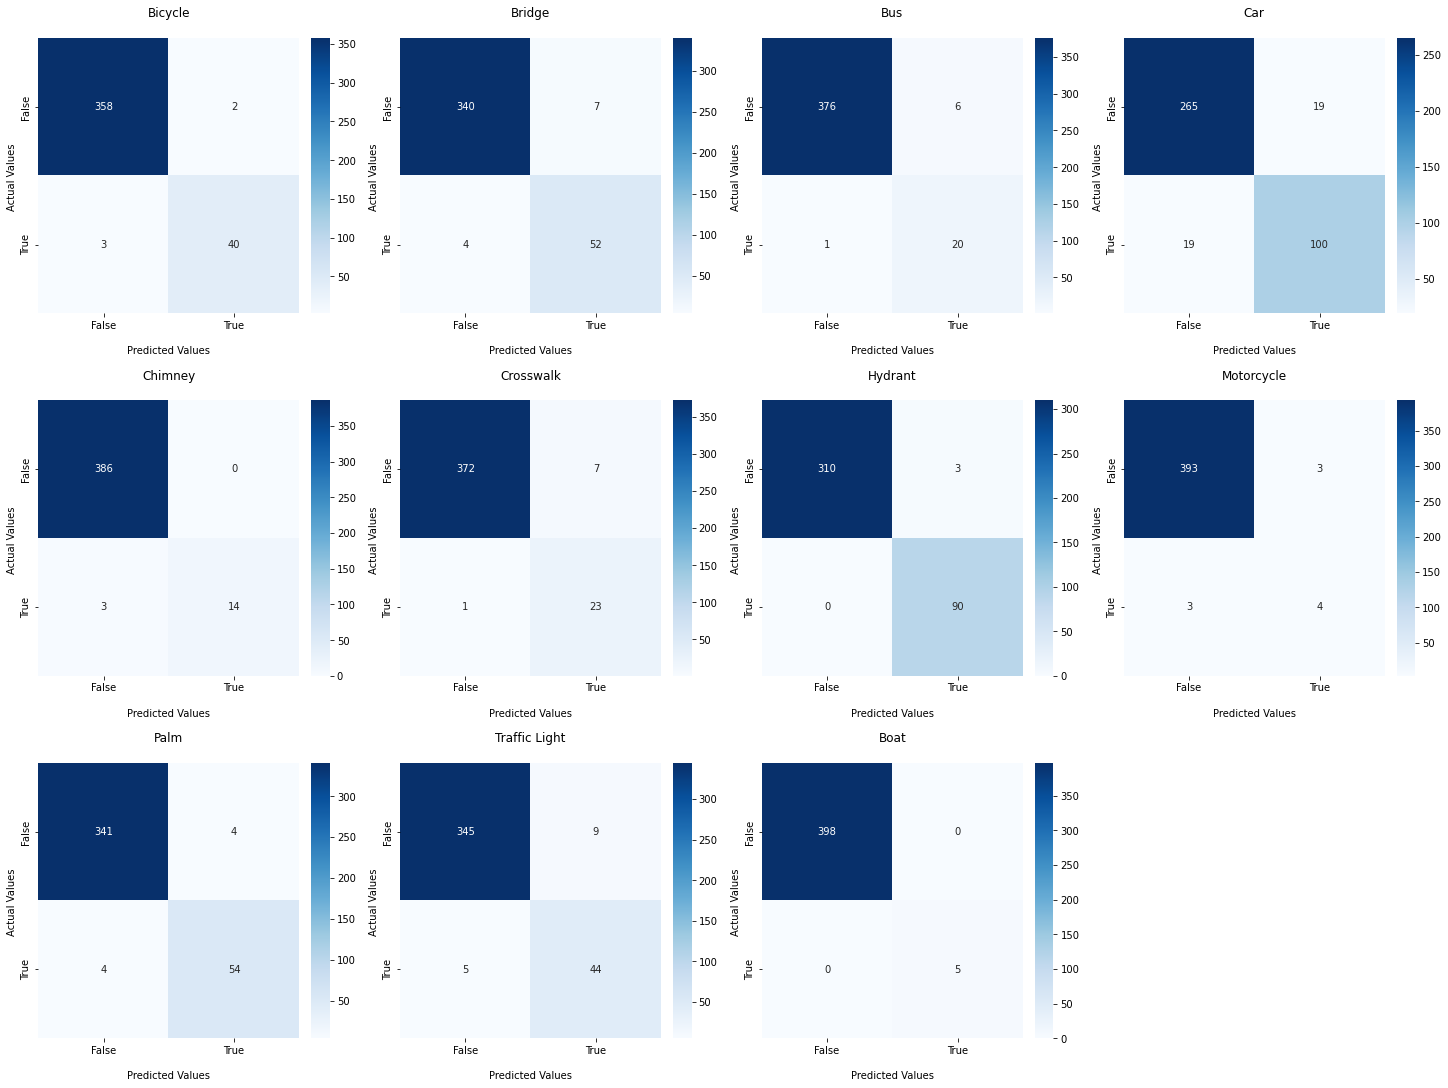

In [ ]:
disp_heatmap_per_class(conf_matrix)  
 

# Calculate Precision, Recall, F1-Score using confusion matrix

In [ ]:
metrics

,Precision,Recall,F1-score
Bicycle,0.952400,0.930200,0.941200
Bridge,0.881400,0.928600,0.904400
Bus,0.769200,0.952400,0.851100
Car,0.840300,0.840300,0.840300
Chimney,1.000000,0.823500,0.903200
Crosswalk,0.766700,0.958300,0.851900
Hydrant,0.967700,1.000000,0.983600
Motorcycle,0.571400,0.571400,0.571400
Palm,0.931000,0.931000,0.931000
Traffic Light,0.830200,0.898000,0.862800


# Identify False Positives (FP) and True Negatives (TN) examples per class 

In [ ]:
def FP_TN_per_class(true_labels,pred_labels):
  p = np.argwhere(pred_labels==1)
  tr = np.argwhere(true_labels==1)
  pred_dict={}
  true_dict = {}
  for index in range(11):
    pred_dict[index] = []
    true_dict[index] = []
  for i in p :
    pred_dict[i[1]].append(i[0])
  for i in tr :
    true_dict[i[1]].append(i[0])

  TP_FN_perclass = {}
  for i in range (NUM_CLASSES):

    dic={}
    dic['FP'] = []
    dic['TN'] = []

    l1 = pred_dict[i]
    l2 = true_dict[i]

    for ll in l1:
      if ll in l2:
        l2.remove(ll)
      else :
        dic['FP'].append(ll)
    dic['TN']=l2

    TP_FN_perclass[my_classes[i]]=dic
    #TP_FN_per_class.append(dic)
  return TP_FN_perclass 


# Display FP and TN examples per class (if exist) 

In [ ]:
def display_FP_TN_per_class(TP_FN_per_class)  :
  fig, axes = plt.subplots(5,4, figsize=(20,15),constrained_layout = True)# squeeze=False 

  for ind, i in enumerate (my_classes):
    if ind ==11 : 
      break
    length_FP=len(TP_FN_per_class[i]['FP'])
    length_TN=len(TP_FN_per_class[i]['TN'])
    plot_size1 = min(1,length_FP)
    plot_size2 = min(1,length_TN)
    #fig, axes = plt.subplots(1,plot_size1+plot_size2, figsize=(25/6*(plot_size1+plot_size2), 25), squeeze=False ,constrained_layout = True)
    if plot_size1!=0:
      for j in range(plot_size1):
        ax = axes[ind//2,2*(ind%2)+j]
        id_example = TP_FN_per_class[i]['FP'][j]
        ax.imshow(ds_test_images[id_example])
        ax.set_title(i+'#'+str(id_example)+" / "+str(round(score_pred[id_example][ind],1))+"% / False Positive")
    else:
      j = -1
    #plt.show()
    for k in range(plot_size2):
      ax = axes[ind//2,k+2*(ind%2)+j+1]
      id_example = TP_FN_per_class[i]['TN'][k]
      ax.imshow(ds_test_images[id_example])
      ax.set_title(i+"#"+str(id_example)+" / "+str(round(score_pred[id_example][ind],1))+ "% / True Negative")
  plt.show()





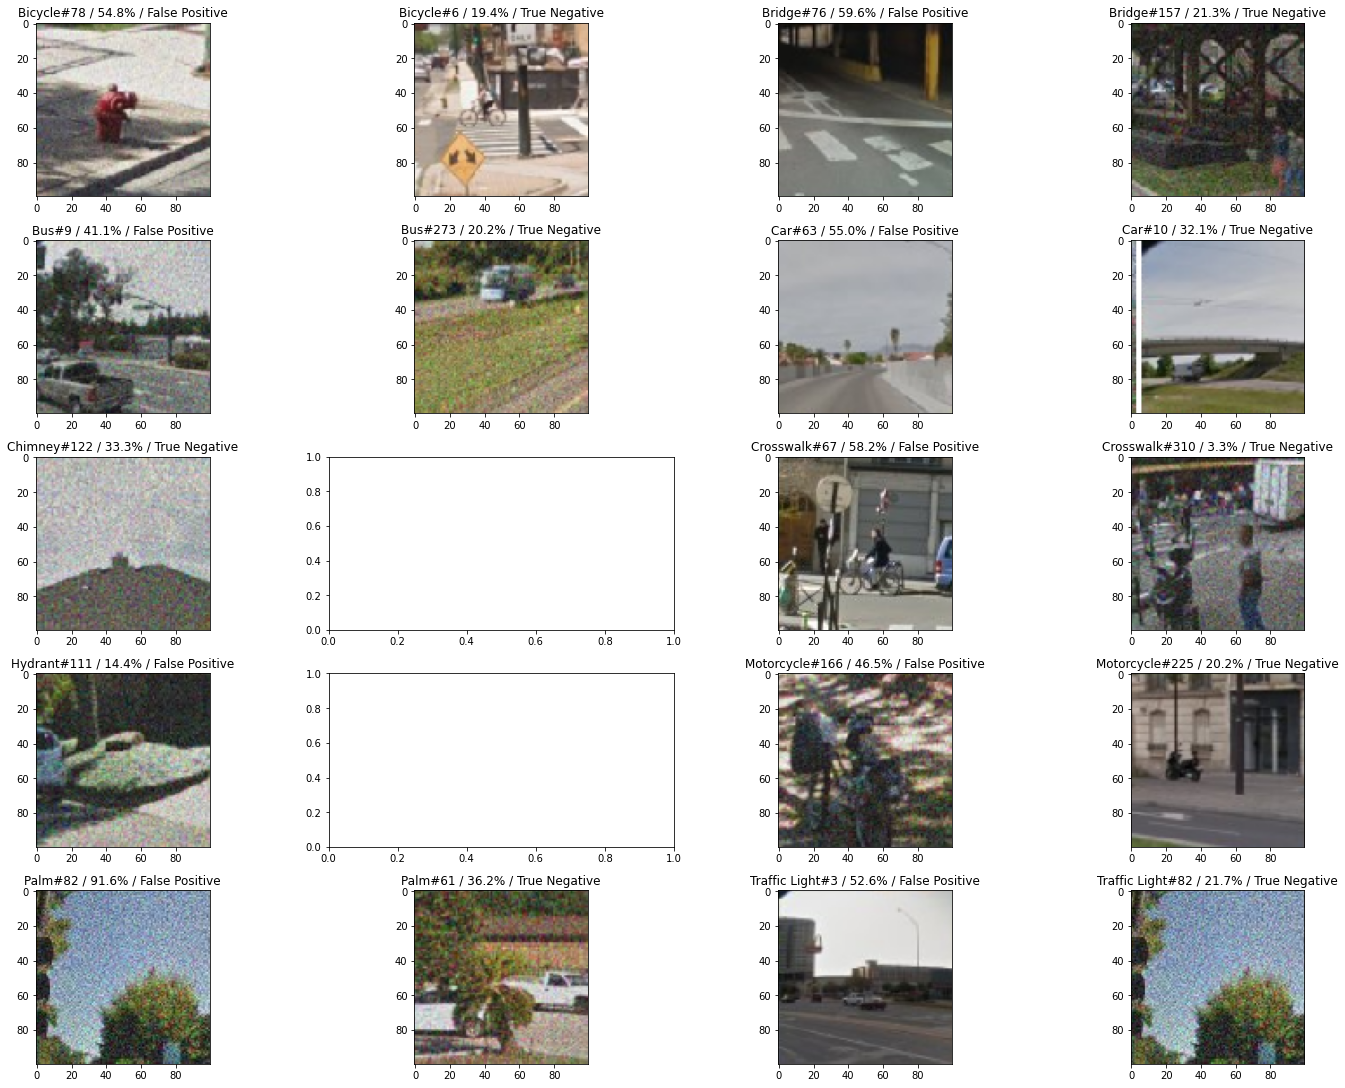

In [ ]:
FP_TN_perclass= FP_TN_per_class(*tr_pr_labels)  #FP_TN_perclass['Bus']

display_FP_TN_per_class(FP_TN_perclass)

## Get detailed information about any image on inference

True       : Bicycle, Car, Crosswalk, Traffic Light
Predict    : Car, Crosswalk, Traffic Light
Confidence : 76.42, 92.33, 56.53


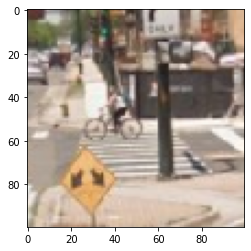

In [ ]:
####  True and predict label for image from ds_test ####

def onehot_to_string(vec):
  label = [my_classes[x[0]] for x in np.argwhere(vec==1)]  
  return (', '.join(label))


def info(id, disp = False, labels=tr_pr_labels):
  conf_id = [round(score_pred[id][x[0]],2) for x in np.argwhere(labels[1][id]==1)]
  print ("True       : " + onehot_to_string(labels[0][id]))
  print ("Predict    : " + onehot_to_string(labels[1][id]))
  print ("Confidence : "+', '.join(str(e) for e in conf_id))
  if disp:
    plt.imshow(ds_test_images[id])
    plt.show()

info(6,True)